## Imports

In [1]:
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.decomposition import PCA
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
E:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data cleaning, preprocessing and Exploratory Data Analysis

In [2]:
#fakenews AMT dataset
dir_path_fake = 'datasets/umich/fakeNewsDataset/fake'
dir_path_real = 'datasets/umich/fakeNewsDataset/legit'

directory_fake = os.fsencode(dir_path_fake)
directory_real = os.fsencode(dir_path_real)

df = pd.DataFrame(columns=['text', 'label'])

fake_text_ls = []
fake_label_ls = []
real_text_ls = []
real_label_ls = []

#label fake=1 ----- real=0
for file in os.listdir(directory_fake):
    filename = os.fsdecode(file)

    with open(os.path.join(dir_path_fake, filename), 'r') as f:
        fake_text_ls.append(f.readlines())
        fake_label_ls.append(1)
    
for file in os.listdir(directory_real):
    filename = os.fsdecode(file)

    with open(os.path.join(dir_path_real, filename), 'r') as f:
        real_text_ls.append(f.readlines())
        real_label_ls.append(0)


In [3]:
#combine real and fake labels
df.text = fake_text_ls + real_text_ls
df.label = fake_label_ls + real_label_ls

df['text'] = df.text.astype(str)
df.shape

(480, 2)

In [4]:
def process_text(text):  
  
    # replace unnecessary characters with space
    s = re.sub(r"\\n", " ", str(text).lower())
    s = re.sub(r":", "", s) 
    s = re.sub(r"xa0", "", s)  
    s = re.sub(r"\.", " ", s)
    s = re.sub(r"\,", " ", s)
    s = re.sub(r"\!", " ", s)
    s = re.sub(r"\;", " ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"[^A-Za-z0-9^+-=]", " ", s)    

    # tokenize the lower cased string 
    s = s.split() 

    #keep words with length > 2
    s = [w for w in s if len(w)>2]

    # stop words
    stop_words = list(stopwords.words('english'))
    stop_words.append('said')
    stop_words.append('says')
    stop_words.append('say')

    # Remove stop words  
    s = [w for w in s if not w in stop_words] 

    s = " ".join(s).rstrip()

    return s


def preprocess_df(df):
  
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['punc_count'] = df['text'].apply(lambda x: len(re.findall(r'[^A-Za-z0-9\s]',x)))
    df['sent_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

    sid = SentimentIntensityAnalyzer()
    df['pos'] = df['text'].apply(lambda x: sid.polarity_scores(x)['pos'])
    df['neg'] = df['text'].apply(lambda x: sid.polarity_scores(x)['neg'])

    df['text'] = df['text'].apply(lambda x: process_text(x))

    return df

In [5]:
df = preprocess_df(df)
df.head()

,text,label,word_count,punc_count,sent_count,pos,neg
0,alex jones vindicated pizzagate controversy al...,1,214,41,8,0.084,0.122
1,big data conspiracy government silicon valley ...,1,102,26,3,0.052,0.079
2,california surprisingly lenient auto emissions...,1,102,27,6,0.174,0.036
3,mexicans chomping bit stop nafta renegotiation...,1,130,29,4,0.122,0.016
4,breaking news snapchat purchase twitter 255 bi...,1,108,21,5,0.028,0.039


# of fake articles:  240
# of real articles:  240


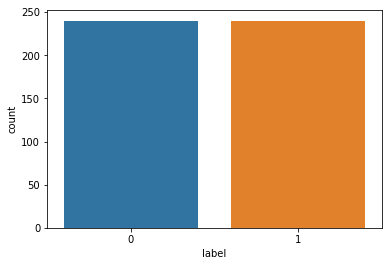

In [6]:
print('# of fake articles: ',list(df.label).count(1))
print('# of real articles: ',list(df.label).count(0))

sns.countplot(df.label)

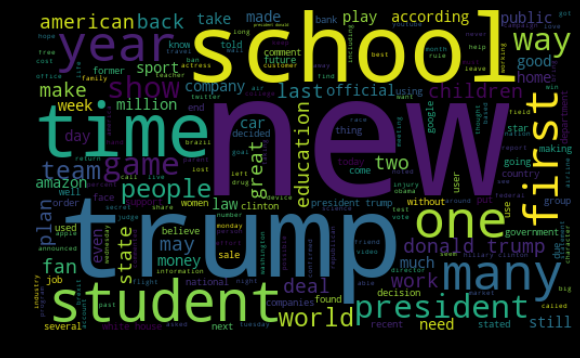

In [7]:
#wordcloud of fake labels
t = list(df['text'][df['label']==1].values)
text = ' '.join(t)
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black').generate(text)
fig = plt.figure(
    figsize = (8, 6),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

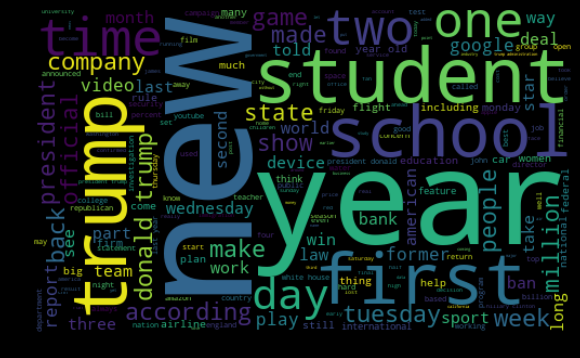

In [8]:
#wordcloud of real labels
t = list(df['text'][df['label']==0].values)
text = ' '.join(t)
wordcloud = WordCloud(
    width = 500,
    height = 300,
    background_color = 'black').generate(text)
fig = plt.figure(
    figsize = (8, 6),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Apply models

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [10]:
def perform_cross_validation(clf, data, labels, folds, metrics):    
    cv = cross_validate(clf, data, labels, scoring=metrics, cv=folds, return_train_score=True)    
    return cv

### CNN

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state=1, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(360,)
(120,)


In [12]:
# convert documents to list of tokens
statements = X_train.apply(lambda x: nltk.word_tokenize(x)).values.tolist()

In [13]:
# load word2vec model
w2v_model = Word2Vec(statements, min_count=1)
print(w2v_model)

Word2Vec(vocab=6892, size=100, alpha=0.025)


In [14]:
# vocabulary
words = list(w2v_model.wv.vocab)

model_vecs = w2v_model[w2v_model.wv.vocab]
print(model_vecs.shape)

(6892, 100)


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [15]:
# keras import
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, GlobalMaxPooling1D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence, text
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [17]:
# Hyperparameters
VOCAB_SIZE = 7000
EMBEDDING_DIMS = model_vecs.shape[1]
MAX_SEQUENCE_LENGTH = 1000
FILTERS = 150 #number of filters
KERNEL_SIZE = 7 #filter window size
BATCH_SIZE = 32

In [18]:
#zero padding
tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

train = tokenizer.texts_to_matrix(X_train)
test = tokenizer.texts_to_matrix(X_test)

print(train.shape)

train = sequence.pad_sequences(train, maxlen=MAX_SEQUENCE_LENGTH)
test = sequence.pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

(360, 7000)


In [19]:
train.shape

(360, 1000)

In [21]:
# using pretrained glove

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIMS))

embeddings_index = dict()
f = open('word_embeddings/glove.6B/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

for word, index in tokenizer.word_index.items():
    if index > VOCAB_SIZE - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

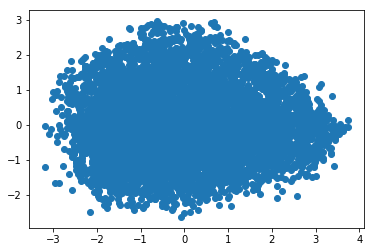

In [22]:
# plot PCA of word embeddings
pca = PCA(n_components=2).fit_transform(embedding_matrix)

plt.scatter(pca[:,0], pca[:,1])

# to annotate each point with word label
# for i, word in enumerate(words):
#   plt.annotate(word, xy=(pca[i, 0], pca[i, 1]))

plt.show()


In [23]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(VOCAB_SIZE,
                            EMBEDDING_DIMS,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.5)(embedded_sequences)
x = Conv1D(FILTERS, KERNEL_SIZE, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(FILTERS, KERNEL_SIZE, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(FILTERS, KERNEL_SIZE, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(FILTERS, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

Training model.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         700000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 994, 150)          105150    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 192, 150)          157650    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 150)           0         
__________

In [26]:
EPOCHS = 100

history = model.fit(train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
360/360 [==============================] - 12s 33ms/step - loss: 0.7021 - acc: 0.5083
Epoch 2/100
360/360 [==============================] - 8s 22ms/step - loss: 0.6964 - acc: 0.5361
Epoch 3/100
360/360 [==============================] - 9s 24ms/step - loss: 0.7003 - acc: 0.5111
Epoch 4/100
360/360 [==============================] - 11s 31ms/step - loss: 0.6886 - acc: 0.5222
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 0.6852 - acc: 0.5611
Epoch 6/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6852 - acc: 0.5417
Epoch 7/100
360/360 [==============================] - 8s 23ms/step - loss: 0.6774 - acc: 0.5556
Epoch 8/100
360/360 [==============================] - 8s 22ms/step - loss: 0.7065 - acc: 0.5389
Epoch 9/100
360/360 [==============================] - 11s 30ms/step - loss: 0.6863 - acc: 0.5

360/360 [==============================] - 11s 29ms/step - loss: 0.5273 - acc: 0.6500
Epoch 80/100
360/360 [==============================] - 11s 29ms/step - loss: 0.5269 - acc: 0.6500
Epoch 81/100
360/360 [==============================] - 10s 27ms/step - loss: 0.5291 - acc: 0.6444
Epoch 82/100
360/360 [==============================] - 7s 20ms/step - loss: 0.5275 - acc: 0.6472
Epoch 83/100
360/360 [==============================] - 7s 21ms/step - loss: 0.5330 - acc: 0.6528
Epoch 84/100
360/360 [==============================] - 10s 29ms/step - loss: 0.5281 - acc: 0.6472
Epoch 85/100
360/360 [==============================] - 11s 30ms/step - loss: 0.5284 - acc: 0.6472
Epoch 86/100
360/360 [==============================] - 9s 24ms/step - loss: 0.5289 - acc: 0.6472
Epoch 87/100
360/360 [==============================] - 7s 20ms/step - loss: 0.5274 - acc: 0.6472
Epoch 88/100
360/360 [==============================] - 9s 25ms/step - loss: 0.5262 - acc: 0.6472
Epoch 89/100
360/360 [======

dict_keys(['loss', 'acc'])


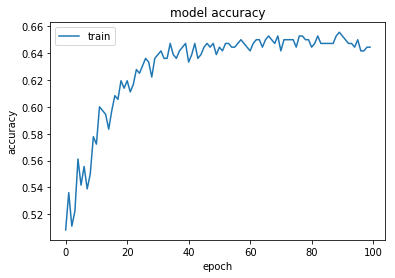

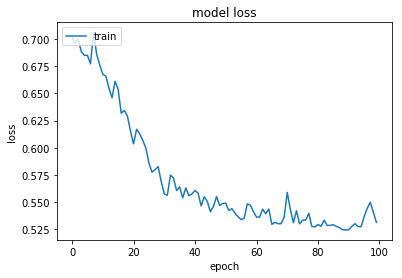

In [28]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [37]:
# predictions using pretrained glove
prediction = model.predict(test) 

print("total test samples:", len(test))

# prediction
cnn_final_preds = np.where(prediction > 0.5, 1, 0) 


print("# of labels predicted as 1(fake):",list(cnn_final_preds).count(1))

total test samples: 120
# of labels predicted as 1(fake): 83


In [38]:
from sklearn.metrics import accuracy_score

print("Accuracy:",accuracy_score(y_test, cnn_final_preds))
print(metrics.classification_report(y_test, cnn_final_preds, labels=[0,1]))

Accuracy: 0.5166666666666667
              precision    recall  f1-score   support

           0       0.65      0.35      0.45        69
           1       0.46      0.75      0.57        51

   micro avg       0.52      0.52      0.52       120
   macro avg       0.55      0.55      0.51       120
weighted avg       0.57      0.52      0.50       120



### Doc2Vec experiment
- It didn't help in improving performace of either model

In [39]:
docs = []
for index, doc in enumerate(df['text']):
    td = TaggedDocument(gensim.utils.to_unicode(str.encode(doc)).split(),[str(index)])
    docs.append(td)
              
docs[:3]

[TaggedDocument(words=['alex', 'jones', 'vindicated', 'pizzagate', 'controversy', 'alex', 'jones', 'purveyor', 'independent', 'investigative', 'news', 'website', 'infowars', 'host', 'alex', 'jones', 'show', 'vindicated', 'claims', 'regarding', 'so-called', 'pizzagate', 'controversy', 'jones', 'others', 'uncovered', 'evidence', 'last', 'year', 'top', 'democratic', 'party', 'officials', 'involved', 'bizarre', 'satanic', 'child', 'sex', 'cult', 'pornography', 'ring', 'using', 'washington', 'pizza', 'parlor', 'comet', 'ping', 'pong', 'pizza', 'front', 'allegations', 'rocked', 'democratic', 'party', 'may', 'caused', 'serious', 'damage', 'hillary', 'clinton', 'presidential', 'campaign', 'top', 'federal', 'investigators', 'confirmed', 'verified', 'many', 'claims', 'executing', 'raids', 'offices', 'several', 'key', 'players', 'charges', 'expected', 'filed', 'coming', 'days', 'news', 'comes', 'welcome', 'vindication', 'jones', 'accused', 'many', 'mainstream', 'media', 'outlets', 'conspiracy', '

In [40]:
model = Doc2Vec(docs,dm = 1, alpha=0.1, size= 100, min_alpha=0.025)

E:\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:535: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [41]:
for epoch in range(20):
    print('iteration {0}'.format(epoch))
    model.train(docs,
                total_examples=model.corpus_count,
                epochs=10)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


In [42]:
df['doc2vec'] = df['text'].apply(lambda x: model.infer_vector(x))

In [43]:
train_doc_vecs = np.matrix(df['doc2vec'].tolist())
print(train_doc_vecs.shape)

(480, 100)


### SVM

In [65]:
### GridSearch using SVM to decide best params for TF-IDF ###

# using f1 as scoring parameter for grid serach
metric = 'f1'

# developing pipeline of features and classifier
clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', svm.LinearSVC())
])

# dictionary of hyperparameters to be tuned
params = {        
    'tfidf__min_df':[1,2,3,5,7],
    'tfidf__ngram_range':[(1,3),(1,4), (1,5), (1,6)],
    'tfidf__analyzer':['word', 'char_wb']
}

# developing gridsearch model
gs_clf = GridSearchCV(clf, param_grid=params, scoring=metric, cv=5)

# fitting model on train set for hyperparameter tuning
gs_clf_fitted = gs_clf.fit(df['text'], df['label'])

# printing best params 
for param in gs_clf_fitted.best_params_:
    print(param, ":", gs_clf_fitted.best_params_[param])

print("Best f1 score: ", gs_clf_fitted.best_score_ )

tfidf__analyzer : char_wb
tfidf__min_df : 3
tfidf__ngram_range : (1, 6)
Best f1 score:  0.6470967741935484


In [44]:
# TF-IDF 

# choose tfidf params based on gridsearch output
tfidf_ = TfidfVectorizer(ngram_range=(1, 6), min_df=3, analyzer='char_wb').fit_transform(df['text']).toarray()

print(tfidf_.shape)

(480, 28993)


In [45]:
##### Training model #####

# Using SVM with linear kernel for classification
svm_clf = svm.LinearSVC()

#5-fold cross validation
cv_svm = perform_cross_validation(svm_clf, tfidf_, df['label'], 5, ['accuracy', 'precision', 'recall', 'f1']) 

In [46]:
##### Report scores #####
# scores on test set using 5-fold cross validation

print("Average test accuracy:", np.mean(cv_svm['test_accuracy'])*100)
print("Average test precision:", np.mean(cv_svm['test_precision'])*100)
print("Average test recall:", np.mean(cv_svm['test_recall'])*100)
print("Average test f1_score:", np.mean(cv_svm['test_f1'])*100)

Average test accuracy: 63.33333333333334
Average test precision: 63.767639275526676
Average test recall: 64.58333333333333
Average test f1_score: 63.66158879448592


### MNB

In [69]:
### GridSearch using Multinomial Naive Bayes to decide best params for TF-IDF ###

# using f1 as scoring parameter for grid serach
metric = 'f1'

# developing pipeline of features and classifier
clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# dictionary of hyperparameters to be tuned
params = {        
    'tfidf__min_df':[3,5,7],
    'tfidf__ngram_range':[(1,3),(1,6)],
    'tfidf__analyzer':['word','char_wb'],
    'clf__alpha':[2,3,4,5]
}

# developing gridsearch model
gs_clf = GridSearchCV(clf, param_grid=params, scoring=metric, cv=5)

# fitting model on train set for hyperparameter tuning
gs_clf_fitted = gs_clf.fit(df['text'], df['label'])

# printing best params 
for param in gs_clf_fitted.best_params_:
    print(param, ":", gs_clf_fitted.best_params_[param])

print("Best f1: ", gs_clf_fitted.best_score_ )

clf__alpha : 2
tfidf__analyzer : char_wb
tfidf__min_df : 3
tfidf__ngram_range : (1, 3)
Best f1:  0.6183344900775194


In [47]:
# TF-IDF 

# choose tfidf params based on gridsearch output
tfidf_ = TfidfVectorizer(ngram_range=(1, 3), min_df=3, analyzer='char_wb').fit_transform(df['text']).toarray()

print(tfidf_.shape)

(480, 4111)


In [48]:
mnb = MultinomialNB(alpha=2)

#5-fold cross validation
cv_mnb = perform_cross_validation(mnb, tfidf_, df['label'], 5, ['accuracy', 'precision', 'recall', 'f1'])

In [49]:
##### Report scores #####
# scores on test set using 5-fold cross validation

print("Average test accuracy:", np.mean(cv_mnb['test_accuracy'])*100)
print("Average test precision:", np.mean(cv_mnb['test_precision'])*100)
print("Average test recall:", np.mean(cv_mnb['test_recall'])*100)
print("Average test f1_score:", np.mean(cv_mnb['test_f1'])*100)

Average test accuracy: 61.875
Average test precision: 61.27828451543873
Average test recall: 66.25
Average test f1_score: 63.25648533915732


### Voting Classifier

In [50]:
# TF-IDF

# choose tfidf params 
tfidf_ = TfidfVectorizer(ngram_range=(1,3),min_df=3).fit_transform(df['text']).toarray()

print(tfidf_.shape)

(480, 3056)


In [51]:
svm_clf = svm.LinearSVC()
mnb = MultinomialNB(alpha=2)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1)

# tried adding below classifiers to the ensemble but it didn't improve performance
# ada_clf = AdaBoostClassifier(n_estimators=100)
# lr = LogisticRegression() 

eclf = VotingClassifier(estimators=[('svm', svm_clf), ('mnb', mnb), ('rf_clf', rf_clf)], voting='hard')

#5-fold cross validation
cv_eclf = perform_cross_validation(eclf, tfidf_, df['label'], 5, ['accuracy', 'precision', 'recall', 'f1'])

In [52]:
##### Report scores #####

# scores on test set using 5-fold cross validation

print("Average test accuracy:", np.mean(cv_eclf['test_accuracy'])*100)
print("Average test precision:", np.mean(cv_eclf['test_precision'])*100)
print("Average test recall:", np.mean(cv_eclf['test_recall'])*100)
print("Average test f1_score:", np.mean(cv_eclf['test_f1'])*100)

Average test accuracy: 63.54166666666667
Average test precision: 63.0973016165714
Average test recall: 66.25
Average test f1_score: 64.24772747988499


#### Custom voting classifier

In [53]:
## SVM ##
# choose tfidf params based on svm gridsearch output
tfidf_svm = TfidfVectorizer(ngram_range=(1, 6), min_df=3, analyzer='char_wb')
tfidf_svm_train = tfidf_svm.fit_transform(X_train).toarray()
tfidf_svm_test = tfidf_svm.transform(X_test).toarray()

svm_clf = svm.LinearSVC()
svm_preds = svm_clf.fit(tfidf_svm_train, y_train).predict(tfidf_svm_test)

## MNB ##
# choose tfidf params based on mnb gridsearch output
tfidf_mnb = TfidfVectorizer(ngram_range=(1, 3), min_df=3, analyzer='char_wb')
tfidf_mnb_train = tfidf_mnb.fit_transform(X_train).toarray()
tfidf_mnb_test = tfidf_mnb.transform(X_test).toarray()

mnb_clf = MultinomialNB(alpha=2)
mnb_preds = mnb_clf.fit(tfidf_mnb_train, y_train).predict(tfidf_mnb_test)

In [54]:
# CNN + SVM + MultinomialNB
all_preds = np.hstack((cnn_final_preds, svm_preds.reshape(-1,1)))
all_preds = np.hstack((all_preds, mnb_preds.reshape(-1,1)))
print(all_preds.shape)

total_votes = np.sum(all_preds,axis=1)

voted_preds = [1 if x > 1 else 0 for x in total_votes ]

(120, 3)


In [55]:
print("Accuracy:",metrics.accuracy_score(y_test, voted_preds))
print(metrics.classification_report(y_test, voted_preds, labels=[0,1]))

Accuracy: 0.45
              precision    recall  f1-score   support

           0       0.62      0.12      0.20        69
           1       0.43      0.90      0.58        51

   micro avg       0.45      0.45      0.45       120
   macro avg       0.52      0.51      0.39       120
weighted avg       0.54      0.45      0.36       120

